In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from tqdm import tqdm
from kerasbeats import prep_time_series, NBeatsModel
from keras import optimizers
import sys
import os
module_path = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath('nbeats.ipynb')),'..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from data import preprocess, postprocess
from model import fft, lstm
from evaluate import evaluateModel, evaluateProfit

In [2]:
stock_name = "^GSPC"
date_predict_start = '2015-01-01'
window_length = 400
slide_range = 50
total_windows = 10

pv_range = 7
profit_percentage = 0.08
loss_percentage = 0.08

n_harm_lower_limit = 1
n_harm_upper_limit = 50
fit_method = 'rmse'

x_length = 150
y_length = 50
slide = y_length

train_data_num = 50
epochs = 5
input_num = 6

In [3]:
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import yfinance as yf


class LoadData:
    """
    Class to load and split stock data.

    Attributes:
        stock_name (str): Name of the stock.
        window_length (int): Length of the window for splitting data.
        slide_range (int): Range of sliding window for splitting data.
        total_windows (int): Total number of windows for splitting data.
        columns_num (int): Number of columns to consider from the stock data.
        columns (list): List of column names to consider from the stock data.
        train_data (numpy.ndarray): Array to store training data. Shape: (total_windows, window_length, columns_num)
        train_data_index (numpy.ndarray): Array to store indices of training data. Shape: (total_windows, window_length)
        test_data (numpy.ndarray): Array to store testing data. Shape: (total_windows, window_length, columns_num)
        test_data_index (numpy.ndarray): Array to store indices of testing data. Shape: (total_windows, window_length)
    """

    def __init__(self, stock_name, window_length, slide_range, total_windows, input_num=1):
        self.stock_name = stock_name
        self.window_length = int(window_length)
        self.slide_range = int(slide_range)
        self.total_windows = int(total_windows)
        self.columns_num = input_num - 1 if input_num != 1 else 1
        self.columns = ['Close', 'Open', 'High', 'Low', 'Volume']
        self.train_data = np.zeros(shape=(total_windows, window_length, self.columns_num), dtype=float)
        self.train_data_index = np.zeros(shape=(total_windows, window_length), dtype=object)
        self.test_data = np.zeros(shape=(total_windows, window_length, self.columns_num), dtype=float)
        self.test_data_index = np.zeros(shape=(total_windows, window_length), dtype=object)

        self.date_data_start_list = []
        self.date_predict_start_list = []
        self.date_predict_end_list = []
        self.test_data_start_list = []

    def load_and_split_data(self, date_predict_start):
        """
        Load and split data into training and testing sets.

        Args:
            date_predict_start (str): Start date for prediction.

        Returns:
            Tuple containing training data, testing data, training data indices, testing data indices, and all data.
        """
        all_data = yf.Ticker(self.stock_name).history(period='max').drop(columns=['Dividends', 'Stock Splits'])
        all_data.index = all_data.index.date
        date_predict_start = self._check_start(date_predict_start, all_data)
        predict_start = all_data.index.get_loc(date_predict_start)
        for i in range(self.total_windows):
            predict_end = predict_start + self.window_length
            data_start = predict_start - self.window_length
            self.train_data[i, :] = all_data[self.columns[:self.columns_num]].iloc[data_start:predict_start].values
            self.train_data_index[i, :] = all_data.iloc[data_start:predict_start].index
            self.test_data[i, :] = all_data[self.columns[:self.columns_num]].iloc[predict_start:predict_end].values
            self.test_data_index[i, :] = all_data.iloc[predict_start:predict_end].index
            predict_start = predict_start + self.slide_range
        return self.train_data, self.test_data, self.train_data_index, self.test_data_index, all_data

    def _check_start(self, date_predict_start, all_data):
        """
        Check if the prediction start date is valid.

        Args:
            date_predict_start (str): Start date for prediction.
            all_data (pd.DataFrame): All stock data.

        Returns:
            Valid start date for prediction.
        """
        date_predict_start = pd.to_datetime(date_predict_start)
        valid_date = all_data.index.asof(date_predict_start)
        return valid_date


In [4]:
dataloader = LoadData(stock_name, window_length, slide_range, total_windows, input_num)
train_data, test_data, train_data_index, test_data_index, all_data =\
    dataloader.load_and_split_data(date_predict_start)


C:\Users\e4903\AppData\Local\Temp\ipykernel_1504\2969846758.py:79: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  valid_date = all_data.index.asof(date_predict_start)


In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler


class Preprocess:
    """
    Class to preprocess training and testing data.

    Attributes:
        x_length (int): Length of the input sequence.
        y_length (int): Length of the target sequence.
    """

    def __init__(self, x_length, y_length):
        self.x_length = x_length
        self.y_length = y_length

    def preprocess_train_data(self, train_data):
        """
        Preprocess training data.

        Args:
            train_data (numpy.ndarray): Training data. Shape: (number of windows, window length, number of features)
            self.x_length (int): Length of the input sequence.
            self.y_length (int): Length of the target sequence.

        Returns:
            Tuple containing preprocessed input data, target data, and scaler object.
        """
        split_num = len(range(self.x_length, train_data.shape[1]-self.y_length))
        train_x = np.zeros((train_data.shape[0], split_num, self.x_length, train_data.shape[-1]))
        train_y = np.zeros((train_data.shape[0], split_num, self.y_length))
        scaler = MinMaxScaler(feature_range=(0, 1))
        for window in range(train_data.shape[0]):
            for columns in range(train_data.shape[-1]):
                scaled_data_train = scaler.fit_transform(train_data[window, :, columns].reshape(-1, 1)).flatten()
                split_count = 0
                for i in range(self.x_length, len(scaled_data_train)-self.y_length):
                    train_x[window, split_count, :, columns] = scaled_data_train[i-self.x_length :i]
                    if columns == 0:
                        train_y[window, split_count] = scaled_data_train[i:i+self.y_length]
                    split_count += 1
        return train_x, train_y, scaler

    def preprocess_test_data(self, train_data, test_data):
        """
        Preprocess testing data.

        Args:
            train_data (numpy.ndarray): Data used for scaling. Shape: (number of windows, window length, number of features)
            test_data (numpy.ndarray): Testing data. Shape: (number of windows, window length, number of features)
            self.x_length (int): Length of the input sequence.
            self.y_length (int): Length of the target sequence.
            slide (int): Sliding window step size.

        Returns:
            Tuple containing preprocessed input data, target data, and scaler object.
        """
        slide = self.y_length
        split_num = len(range(train_data.shape[1], train_data.shape[1]+test_data.shape[1]-self.y_length, slide))
        test_x = np.zeros((test_data.shape[0], split_num, self.x_length, test_data.shape[-1]))
        test_y = np.zeros((test_data.shape[0], split_num, self.y_length))
        scaler = MinMaxScaler(feature_range=(0, 1))
        concat_data = np.concatenate([train_data, test_data], axis=1)
        for window in range(test_data.shape[0]):
            for columns in range(test_data.shape[-1]):
                scaled_data = scaler.fit_transform(concat_data[window, :, columns].reshape(-1, 1)).flatten()
                split_count = 0
                for i in range(train_data.shape[1], len(scaled_data)-self.y_length, slide):
                    test_x[window, split_count, :, columns] = scaled_data[i-self.x_length:i]
                    if columns == 0:
                        test_y[window, split_count] = scaled_data[i:i+self.y_length]
                    split_count += 1
        return test_x, test_y


In [6]:
# extra_train_data, extra_train_data_index = dataloader.load_extra_train_data(date_predict_start, train_data_num, x_length)
all_data_index = all_data.index
preprocesser = Preprocess(x_length, y_length)
x_train, y_train, scaler =\
    preprocesser.preprocess_train_data(train_data)
x_test, y_test =\
    preprocesser.preprocess_test_data(train_data, test_data)

In [7]:
import matplotlib.pyplot as plt

In [8]:
x_train.shape

(10, 200, 150, 5)

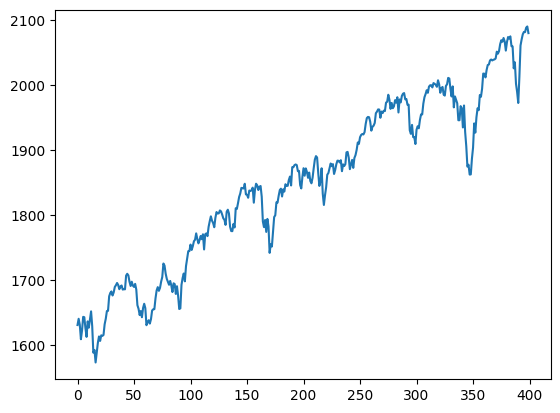

In [9]:
plt.plot(train_data[0, :, 0])

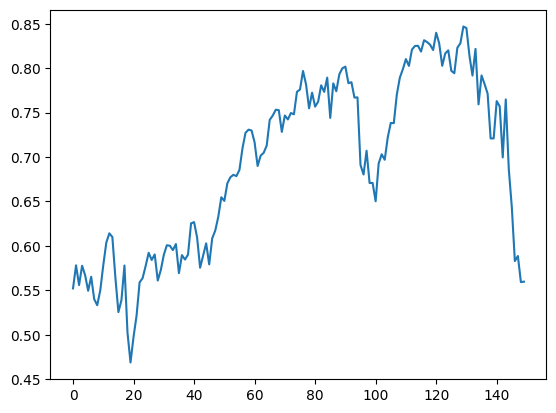

In [10]:
plt.plot(x_train[0, -1, :, 0])

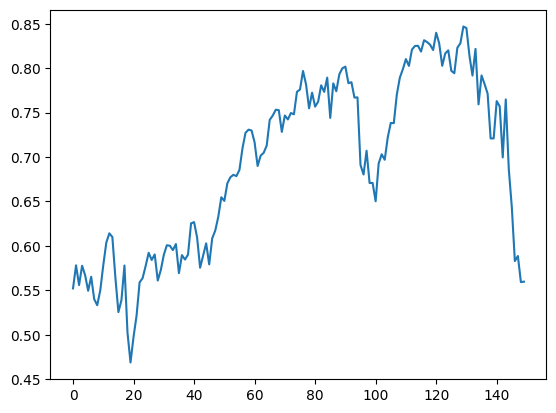

In [11]:
plt.plot(x_train[0, -1, :, 0])

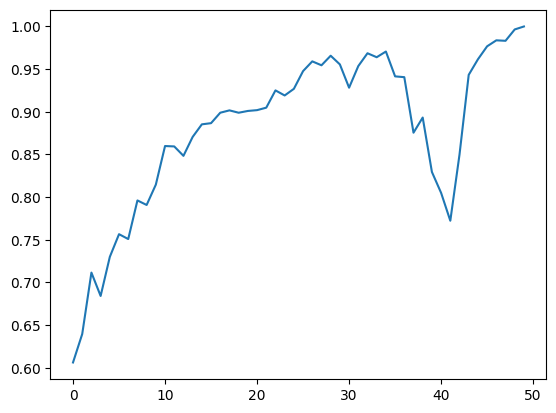

In [12]:
plt.plot(y_train[0, -1])

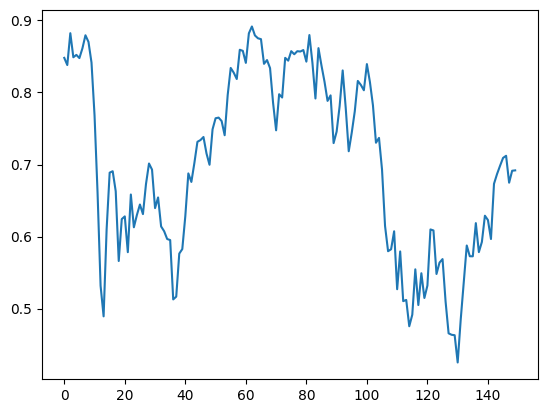

In [13]:
plt.plot(x_test[0, -1, :, 0])

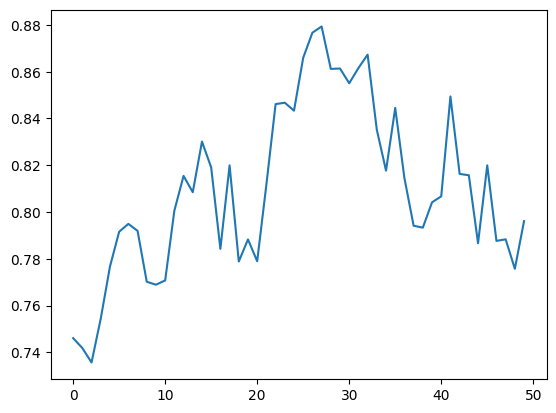

In [14]:
plt.plot(y_test[0, -1])

In [15]:
class Nbeats:
    def __init__(self):
        pass
    
    def nbeats(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(train_data, model, x_train, y_train, epochs)
        predicted_y = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history

    def _construct(self, y_length):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = NBeatsModel(model_type = 'generic', lookback = 1, horizon = y_length)
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        model = self._construct(y_length)
        # model[i].compile(loss = 'mse',
        #          optimizer = optimizers.RMSprop(0.001))
        # model[i].summary()
        return model
    
    def _train(self, train_data, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
        history = model.fit(x_train, y_train, epochs=epochs)
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y

In [16]:
class Lstm:
    def __init__(self):
        pass
    
    def lstm(self, x_train, y_train, x_test, y_test, train_data, test_data, y_length, epochs):
        """
        Trains and predicts using LSTM model.

        Args:
            x_train (array): Training input data.
            y_train (array): Training target data.
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            train_data (array): Training data.
            y_length (int): Length of the target data.

        Returns:
            array: Processed signal obtained from predictions.
        """
        model = self._build(x_train, y_length)
        history = self._train(model, x_train, y_train, epochs)
        predicted_y, evaluate = self._predict(x_test, y_test, test_data, model)
        # processed_signal = self._flatten(predicted_y)
        return predicted_y, history, evaluate

    def _construct(self, y_length, input_shape):
        """
        Constructs an LSTM model.

        Args:
            y_length (int): Length of the target data.
            input_shape (tuple): Shape of the input data.

        Returns:
            Sequential: Constructed LSTM model.
        """
        model = Sequential()
        model.add(LSTM(units = 256, return_sequences = True, input_shape = input_shape))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 128, return_sequences = True))
        model.add(Dropout(0.4))
        model.add(LSTM(units = 64))
        model.add(Dropout(0.4))
        model.add(Dense(units=y_length))
        return model
    
    def _build(self, x_train, y_length):
        """
        Builds a list of LSTM models.

        Args:
            x_train (array): Training input data.
            y_length (int): Length of the target data.

        Returns:
            list: List of built LSTM models.
        """
        input_shape = (x_train.shape[-2], x_train.shape[-1])
        print(input_shape)
        model = self._construct(y_length, input_shape)
        model.compile(optimizer='adam', 
                    loss='mean_squared_error')
            # model[i].summary()
        return model
    
    def _train(self, model, x_train, y_train, epochs):
        """
        Trains the LSTM models.

        Args:
            train_data (array): Training data.
            model (list): List of LSTM models.
            x_train (array): Training input data.
            y_train (array): Training target data.

        Returns:
            list: List of training histories.
        """
        earlystopper = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1)
        history = list()
        for window in range(0, x_train.shape[0]):
            history.append(model.fit(x_train[window], y_train[window], epochs=epochs, batch_size=32, 
                                callbacks = [earlystopper], validation_split = 0.2, shuffle=True))
        return history
    
    def _predict(self, x_test, y_test, test_data, model):
        """
        Generates predictions using the trained models.

        Args:
            x_test (array): Test input data.
            y_test (array): Test target data.
            test_data (array): Data for prediction.
            model (list): List of LSTM models.

        Returns:
            predicted_y: numpy.ndarray
                Processed signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
        """
        predicted_y = np.ndarray([y_test.shape[0], y_test.shape[1], y_test.shape[2]])
        evaluate = np.ndarray([y_test.shape[0], 2])
        for i in tqdm(range(0, test_data.shape[0])):
            predicted_prices = model.predict(x_test[i])
            evaluate[i] = model.evaluate(x_test[i], y_test[i])
            predicted_y[i] = predicted_prices
        return predicted_y, evaluate
    

In [17]:
# model = NBeatsModel(model_type = 'generic', lookback = y_length, horizon = y_length)

In [18]:
# x_train.shape

In [19]:
# x_train[0].flatten().shape

In [20]:
# for i in tqdm(range(0, train_data.shape[0])):
#     earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 2)
#     history = model.fit(x_train[i].flatten(), y_train[i].flatten(), epochs=25)

In [21]:
x_train.shape

(10, 200, 150, 5)

In [22]:
y_train.shape

(10, 200, 50)

In [23]:
x_test.shape

(10, 7, 150, 5)

In [24]:
y_test.shape

(10, 7, 50)

In [25]:
import numpy as np
import math

class Postprocess:
    """A class for postprocessing signals."""
    def __init__(self):
        pass

    def postprocess_lstm(self, predicted_y, scaler):
        """Postprocess the predicted LSTM signal.

        Args:
            predicted_y: numpy.ndarray
                Predicted signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)
            scaler: object
                Scaler object used for inverse transformation.

        Returns:
            processed_lstm_signal: numpy.ndarray
                Processed signal flattened from predicted_y.
                shape = (number of windows, 1, window_length)
        """
        inversed_signal = self._inverse_transfer(predicted_y, scaler)
        processed_lstm_signal = self._flatten(inversed_signal)
        return processed_lstm_signal
    
    def _inverse_transfer(self, predicted_y, scaler):
        """
        Reverse the transformation of the predicted signal.

        Args:
            predicted_y: numpy.ndarray
                Predicted signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)

        Returns:
            processed_signal: numpy.ndarray
                Processed signal flatten from predicted_y.
                shape = (number of windows, 1, window_length)
        """

        inversed_signal = np.zeros_like(predicted_y)
        for window in range(0, predicted_y.shape[0]):
            inversed_signal[window] = scaler.inverse_transform(predicted_y[window])
        return inversed_signal
    
    def _flatten(self, inversed_signal):
        """
        Flatten the predicted signal.

        Args:
            inversed_signal: numpy.ndarray
                Predicted signal obtained from predictions.
                shape = (number of windows, number of split y, length of y)

        Returns:
            processed_signal: numpy.ndarray
                Processed signal flatten from predicted_y.
                shape = (number of windows, 1, window_length)
        """

        flatten_signal = np.ndarray([inversed_signal.shape[0], inversed_signal.shape[1]*inversed_signal.shape[2]])
        for window in range(0, inversed_signal.shape[0]):
            flatten_signal[window] = inversed_signal[window].flatten()
        return flatten_signal
    
    def postprocess_fft(self, mixed_train_harm, mixed_test_harm, pv_range, pv_train_data, fit_method):
        """Postprocess the FFT signal.

        Args:
            mixed_train_harm: numpy.ndarray
                Mixed harmonics of the training data.
                shape: (number of windows, number of mixed harmonics, window_length)
            mixed_test_harm: numpy.ndarray
                Mixed harmonics of the test data.
                shape: (number of windows, number of mixed harmonics, window_length)
            pv_range: int
                The range within which peaks and valleys are detected.
            pv_train_data: numpy.ndarray
                Training data used for finding peaks and valleys.
                shape: (number of windows, window_length)
            fit_method: str
                The method used for fitting the signal.

        Returns:
            processed_signal: numpy.ndarray
                Processed signal.
                shape: (number of windows, window_length)
            best_fit_harm: numpy.ndarray
                Indices of the best fitting harmonics for each window.
                shape: (number of windows)
            best_fit_error: numpy.ndarray
                Error values of the best fitting harmonics for each window.
                shape: (number of windows)
        """
        pv_mixed_train_harm = self.find_data_pv(mixed_train_harm, pv_range)
        lead_mixed_train_harm = self.find_fft_lead(pv_train_data, pv_mixed_train_harm)
        errors = self._get_fit_error(lead_mixed_train_harm, fit_method)
        best_fit_harm, best_fit_error = self._get_best_fit(errors)
        processed_signal = self._pick_best_fit_harm(mixed_test_harm, best_fit_harm)
        return processed_signal, best_fit_harm, best_fit_error

    def find_data_pv(self, data, pv_range):
        '''
        Find peaks and valleys of the data, excluding the first and last data points.

        Args:
            data: numpy.ndarray
                The input data array.
                    fft_processed_signal: numpy.ndarray 
                        The processed signal obtained by mixing the selected harmonics.
                        shape: (number of windows, number of mixed harmonics, window_length)
                        
                    lstm_y: numpy.ndarray
                        Processed signal obtained from predictions.
                        shape = (number of windows, number of split y, length of y)
                        flatten -> (number of windows, window_length)

            pv_range: int
                The range within which peaks and valleys are detected.

        Returns:
            pv: numpy.ndarray
                An array of the same shape as `data`, where peaks are represented by 1,
                valleys are represented by -1, and other points are represented by 0.
                shape: (number of windows, window_length)
        Raises:
            None
        '''
        pv = np.zeros_like(data)
        if len(pv.shape) == 3:
            for window in range(0, data.shape[0]):
                for harmonics in range(0, data.shape[1]):
                    pv[window, harmonics] = self._find_pv(data[window, harmonics], pv_range)
        elif len(pv.shape) == 2:
            for window in range(0, data.shape[0]):
                pv[window] = self._find_pv(data[window], pv_range)
        return pv
    
    def _find_pv(self, data, pv_range):
        """Find peaks and valleys in the data.

        Args:
            data: numpy.ndarray
                The input data array.
            pv_range: int
                The range within which peaks and valleys are detected.

        Returns:
            pv: numpy.ndarray
                Array representing peaks (1), valleys (-1), and other points (0).

        Raises:
            None
        """
        pv = np.zeros_like(data)
        for l in range(1, data.shape[0]): # Ignore pv on the first data point
            if l < pv_range:
                if data[l] == data[:l+pv_range+1].max():
                    pv[l] = 1
                if data[l] == data[:l+pv_range+1].min():
                    pv[l] = -1   
            else:
                if data[l] == data[l-pv_range:l+pv_range+1].max():
                    pv[l] = 1   
                if data[l] == data[l-pv_range:l+pv_range+1].min():
                    pv[l] = -1
        return pv
    
    def _find_peak_lead(self, element, pv_data, pv_signal):
        """Find the lead for a peak element.

        Args:
            element: tuple
                Tuple containing the index and value of the element.
            pv_train_data: numpy.ndarray
                Data array used for finding peaks and valleys.
                shape: (window_length)
            pv_signal: numpy.ndarray
                Signal array containing peaks (1), valleys (-1), and others (0).
                shape: (window_length)

        Returns:
            lead: int
                Lead value for the peak element.

        Raises:
            None
        """
        front = 'NULL'
        back = 'NULL'
        lead = None
        forword = list(range(0, len(pv_signal)-element[0]))
        backword = list(range(0, element[0]+1))
        for i in forword:
            if pv_data[element[0]+i] == 1:
                front = i
                break 
        for i in backword:
            if pv_data[element[0]-i] == 1:
                back = -i
                break
        if front == 'NULL' and back == 'NULL':
            print('no peaks or valleys lead in data')
        elif front != 'NULL' and back == 'NULL':
            lead = front
        elif front == 'NULL' and back != 'NULL':
            lead = back
        elif front <= np.absolute(back):
            lead = front
        elif front > np.absolute(back):
            lead = back
        return lead

    def _find_valley_lead(self, element, pv_train_data, pv_signal):
        """Find the lead for a valley element.

        Args:
            element: tuple
                Tuple containing the index and value of the element.
            pv_train_data: numpy.ndarray
                Data array used for finding peaks and valleys.
                shape: (window_length)
            pv_signal: numpy.ndarray
                Signal array containing peaks (1), valleys (-1), and others (0).
                shape: (window_length)

        Returns:
            lead: int
                Lead value for the valley element.

        Raises:
            None
        """
        front = 'NULL'
        back = 'NULL'
        lead = None
        forword = list(range(0, len(pv_signal)-element[0]))
        backword = list(range(0, element[0]+1))
        for i in forword:
            if pv_train_data[element[0]+i] == -1:
                front = i
                break 
        for i in backword:
            if pv_train_data[element[0]-i] == -1:
                back = -i
                break
        if front == 'NULL' and back == 'NULL':
            print('no peaks or valleys lead in data')
        elif front != 'NULL' and back == 'NULL':
            lead = front
        elif front == 'NULL' and back != 'NULL':
            lead = back
        elif front <= np.absolute(back):
            lead = front
        elif front > np.absolute(back):
            lead = back
        return lead
    
    def find_lead(self, pv_data, pv_signal):
        """Find the lead values for peak and valley elements.

        Args:
            pv_data: numpy.ndarray
                Data array used for finding peaks and valleys.
                shape: (number of windows, window_length)
            pv_signal: numpy.ndarray
                Signal array containing peaks (1), valleys (-1), and others (0).
                shape: (number of windows, window_length)

        Returns:
            lead: numpy.ndarray
                Array containing the lead values for each element.
                shape: (number of windows, window_length)

        Raises:
            None
        """
        lead = np.ndarray([pv_signal.shape[0], pv_signal.shape[1]], dtype='object')
        for window in range(0, pv_signal.shape[0]):
            for element in enumerate(pv_signal[window]):
                if element[1] == 1:
                    lead[window, element[0]] = self._find_peak_lead(element, pv_data[window], pv_signal[window])
                elif element[1] == -1:
                    lead[window, element[0]] = self._find_valley_lead(element, pv_data[window], pv_signal[window])
                else:
                    lead[window, element[0]] = None
        return lead

    def find_fft_lead(self, pv_data, pv_fft_signal):
        """Find the lead values for peak and valley elements in the FFT signal.

        Args:
            pv_data: numpy.ndarray
                Data array used for finding peaks and valleys.
                shape: (number of windows, window_length)
            pv_signal: numpy.ndarray
                Signal array containing peaks (1), valleys (-1), and others (0).
                shape: (number of windows, window_length)

        Returns:
            lead: numpy.ndarray
                Array containing the lead values for each element.
                shape: (number of windows, window_length)

        Raises:
            None
        """
        lead = np.ndarray([pv_fft_signal.shape[0], pv_fft_signal.shape[1], pv_fft_signal.shape[2]], dtype='object')
        for window in range(0, pv_fft_signal.shape[0]):
            for harm in range(0, pv_fft_signal.shape[1]):
                for element in enumerate(pv_fft_signal[window, harm]):
                    if element[1] == 1:
                        lead[window, harm, element[0]] = self._find_peak_lead(element, pv_data[window], pv_fft_signal[window, harm])
                    elif element[1] == -1:
                        lead[window, harm, element[0]] = self._find_valley_lead(element, pv_data[window], pv_fft_signal[window, harm])
                    else:
                        lead[window, harm, element[0]] = None
        return lead
    
    def _compute_error_maen(self, lead):
        """Compute the mean error value.

        Args:
            lead: numpy.ndarray
                Array containing the lead values.

        Returns:
            error: float
                Mean error value.

        Raises:
            None
        """
        error = 0
        for num in lead:
            if num is not None:
                error += num
        return error/lead.shape[0]

    def _compute_error_abs(self, lead):
        """Compute the absolute error value.

        Args:
            lead: numpy.ndarray
                Array containing the lead values.

        Returns:
            error: float
                Absolute error value.

        Raises:
            None
        """
        error = 0
        for num in lead:
            if num is not None:
                error += np.abs(num)
        return error/lead.shape[0]

    def _compute_error_rmse(self, lead):
        """Compute the root mean square error value.

        Args:
            lead: numpy.ndarray
                Array containing the lead values.

        Returns:
            error: float
                Root mean square error value.

        Raises:
            None
        """
        error = 0
        for num in lead:
            if num is not None:
                # error += np.abs(num)
                mse = np.square(num).mean()
                rmse = math.sqrt(mse)
                error += rmse
        return error/lead.shape[0]

    def _get_fit_error(self, lead_mixed_train_harm, fit_method):
        """Compute the error values for fitting.

        Args:
            lead_mixed_train_harm: numpy.ndarray
                Array containing the lead values for each element.
                shape: (number of windows, number of harmonics)
            fit_method: str
                The method used for fitting the signal.

        Returns:
            errors: numpy.ndarray
                Array containing the error values.
                shape: (number of windows, number of harmonics)

        Raises:
            None
        """
        errors = np.ndarray([lead_mixed_train_harm.shape[0], lead_mixed_train_harm.shape[1]])
        error = int()
        for i in range(0, lead_mixed_train_harm.shape[0]):
            for j in range(0, lead_mixed_train_harm.shape[1]):
                if fit_method == 'mean':
                    error = self._compute_error_maen(lead_mixed_train_harm[i, j])
                elif fit_method == 'abs':
                    error = self._compute_error_abs(lead_mixed_train_harm[i, j])
                elif fit_method == 'rmse':
                    error = self._compute_error_rmse(lead_mixed_train_harm[i, j])
                else :
                    print('worng fit_method')
                errors[i, j] = error
        return errors

    def _get_best_fit(self, errors):
        """Get the best fitting harmonics and their error values.

        Args:
            errors: numpy.ndarray
                Array containing the error values.
                shape: (number of windows, number of harmonics)

        Returns:
            best_fit_harm: numpy.ndarray
                Array containing the indices of the best fitting harmonics.
                shape: (number of windows)
            best_fit_error: numpy.ndarray
                Array containing the error values of the best fitting harmonics.
                shape: (number of windows)

        Raises:
            None
        """
        best_fit_harm = np.ndarray(errors.shape[0])
        best_fit_error = np.ndarray(errors.shape[0])
        for window in range(errors.shape[0]):
            best_fit_harm[window] = np.argmin(errors[window])
            best_fit_error[window] = errors[window, int(best_fit_harm[window])]
        return best_fit_harm, best_fit_error

    def _pick_best_fit_harm(self, mixed_test_harm, best_fit_harm):
        """Pick the best fitting harmonics.

        Args:
            mixed_test_harm: numpy.ndarray
                Mixed harmonics of the test data.
                shape: (number of windows, number of mixed harmonics, window_length)
            best_fit_harm: numpy.ndarray
                Array containing the indices of the best fitting harmonics.
                shape: (number of windows)

        Returns:
            processed_signal: numpy.ndarray
                Processed signal.
                shape: (number of windows, window_length)

        Raises:
            None
        """
        processed_signal = np.ndarray([mixed_test_harm.shape[0], mixed_test_harm.shape[2]])
        for window in range(0, mixed_test_harm.shape[0]):
            processed_signal[window] = mixed_test_harm[window, int(best_fit_harm[window])]
        return processed_signal

    def get_first_lead(self, pv_signal, lead_test):
        """Get the first lead values for each window.

        Args:
            pv_signal: numpy.ndarray
                Signal array containing peaks (1), valleys (-1), and others (0).
                shape: (number of windows, window_length)
            lead_test: numpy.ndarray
                Array containing the lead values for each element.
                shape: (number of windows, window_length)

        Returns:
            first_date: numpy.ndarray
                Array containing the index of the first non-zero element in each window.
                shape: (number of windows)
            lead: numpy.ndarray
                Array containing the lead values for each window.
                shape: (number of windows)
            pv: numpy.ndarray
                Array containing the peak/valley values for each window.
                shape: (number of windows)

        Raises:
            None
        """
        first_date = np.zeros(pv_signal.shape[0], dtype=object)
        lead = np.zeros(pv_signal.shape[0], dtype=object)
        pv = np.zeros(pv_signal.shape[0], dtype=object)
        for window in range(0, pv_signal.shape[0]):
            nonzero_indices = np.nonzero(lead_test[window])[0]
            first_nonzero_index = nonzero_indices[0]
            for i in range(0, pv_signal.shape[1]):
                if lead_test[window, i] != None:
                    first_date[window] = i
                    lead[window] = lead_test[window, i]
                    pv[window] = pv_signal[window, i]
                    break
            if pv[window] == 0:
                first_date[window] = None
                lead[window] = None
                pv[window] = None
                print(f'no peaks or valleys lead in data{window}')
        return first_date, lead, pv


In [26]:
post = Postprocess()
pv_x_train = post.find_data_pv(x_train[:,:,:,0].reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2]), pv_range)
pv_x_train = pv_x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = np.concatenate((x_train, pv_x_train), axis=-1)
pv_x_test = post.find_data_pv(x_test[:,:,:,0].reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2]), pv_range)
pv_x_test = pv_x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = np.concatenate((x_test, pv_x_test), axis=-1)

In [27]:
x_train.shape

(10, 200, 150, 6)

In [28]:
pv_x_train.shape

(10, 200, 150, 1)

In [29]:
x_test.shape

(10, 7, 150, 6)

In [30]:
pv_x_test.shape

(10, 7, 150, 1)

In [31]:
model = Lstm()

In [32]:
shuffle_index = np.random.permutation(x_train.shape[1])
x_train_shuffled = x_train[:, shuffle_index]
y_train_shuffled = y_train[:, shuffle_index]

In [33]:
lstm_processed_signal, history, evaluate = model.lstm(x_train_shuffled, y_train_shuffled, x_test, y_test, train_data, test_data, y_length, epochs)

(150, 6)
Epoch 1/5
5/5 [==============================] - 14s 2s/step - loss: 0.3840 - val_loss: 0.1604
Epoch 2/5
5/5 [==============================] - 4s 898ms/step - loss: 0.2435 - val_loss: 0.0897
Epoch 3/5
5/5 [==============================] - 5s 893ms/step - loss: 0.1830 - val_loss: 0.0588
Epoch 4/5
5/5 [==============================] - 4s 855ms/step - loss: 0.1445 - val_loss: 0.0392
Epoch 5/5
5/5 [==============================] - 5s 980ms/step - loss: 0.1237 - val_loss: 0.0252
Epoch 1/5
5/5 [==============================] - 9s 2s/step - loss: 0.1084 - val_loss: 0.0204
Epoch 2/5
5/5 [==============================] - 4s 855ms/step - loss: 0.0952 - val_loss: 0.0213
Epoch 3/5
5/5 [==============================] - 6s 1s/step - loss: 0.0881 - val_loss: 0.0222
Epoch 4/5
5/5 [==============================] - 6s 1s/step - loss: 0.0776 - val_loss: 0.0149
Epoch 5/5
5/5 [==============================] - 5s 1s/step - loss: 0.0671 - val_loss: 0.0143
Epoch 1/5
5/5 [====================

  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 144ms/step - loss: 0.0248


 10%|█         | 1/10 [00:01<00:16,  1.88s/it]

1/1 [==============================] - 0s 136ms/step - loss: 0.0239


 20%|██        | 2/10 [00:02<00:07,  1.01it/s]

1/1 [==============================] - 0s 132ms/step - loss: 0.0200


 30%|███       | 3/10 [00:02<00:04,  1.43it/s]

1/1 [==============================] - 0s 136ms/step - loss: 0.0224


 40%|████      | 4/10 [00:02<00:03,  1.77it/s]

1/1 [==============================] - 0s 139ms/step - loss: 0.0276


 50%|█████     | 5/10 [00:03<00:02,  2.02it/s]

1/1 [==============================] - 0s 139ms/step - loss: 0.0330


 60%|██████    | 6/10 [00:03<00:01,  2.20it/s]

1/1 [==============================] - 0s 135ms/step - loss: 0.0191


 70%|███████   | 7/10 [00:04<00:01,  2.36it/s]

1/1 [==============================] - 0s 137ms/step - loss: 0.0179


 80%|████████  | 8/10 [00:04<00:00,  2.47it/s]

1/1 [==============================] - 0s 140ms/step - loss: 0.0182


 90%|█████████ | 9/10 [00:04<00:00,  2.51it/s]

1/1 [==============================] - 0s 135ms/step - loss: 0.0152


100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


In [34]:
import matplotlib.pyplot as plt

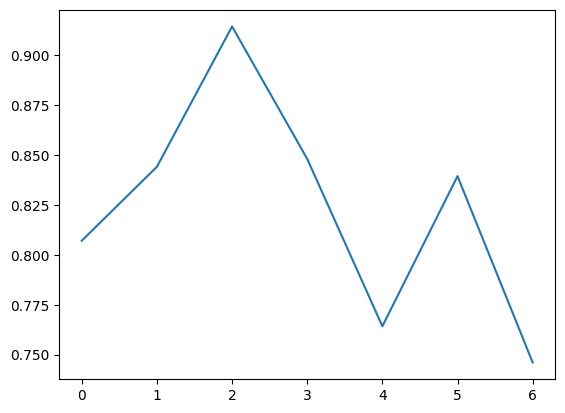

In [35]:
plt.plot(y_test[0,:,0].flatten())

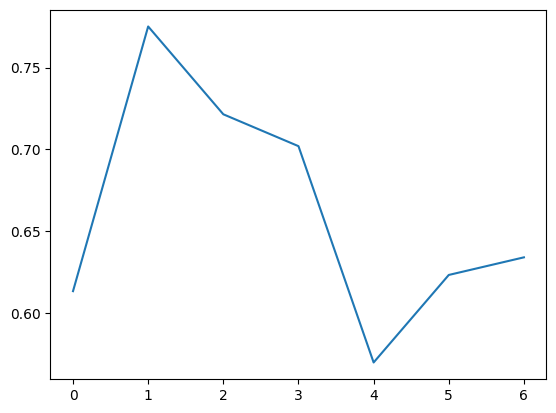

In [36]:
plt.plot(lstm_processed_signal[0,:,0].flatten())

In [37]:
# # initialize N-Beats and fit
# nbeats = NBeatsModel(model_type = 'generic', lookback = x_length, horizon = 1)
# nbeats.fit(x_train[0], y_train[0], epochs = 30)

In [38]:
y_test.shape

(10, 7, 50)

In [39]:
lstm_processed_signal.shape

(10, 7, 50)

In [40]:
post = postprocess.Postprocess()
processed_signal = post.postprocess_lstm(lstm_processed_signal, scaler)
pv_train_data = post.find_data_pv(train_data[:,:,0], pv_range)
pv_test_data = post.find_data_pv(test_data[:,:,0], pv_range)
pv_signal = post.find_data_pv(processed_signal, pv_range)
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [41]:
pv_train_data.shape

(10, 400)

In [42]:
test_data.shape

(10, 400, 5)

In [43]:
pv_signal.shape

(10, 350)

In [44]:
# processed_signal, best_fit_harm, best_fit_error = post.postprocess_fft(
#     mixed_train_harm, mixed_test_harm, pv_range, pv_train_data, fit_method)
# pv_signal = post.find_data_pv(processed_signal, pv_range)

In [45]:
lead_train = post.find_lead(pv_train_data, pv_signal)
lead_test = post.find_lead(pv_test_data, pv_signal)
first_date, lead, pv = post.get_first_lead(pv_signal, lead_test)

In [46]:
best_fit_harm = None
best_fit_error = None

In [47]:
evaluater = evaluateModel.Evaluate()
result_table, average_lead = evaluater.evaluate_model(processed_signal, all_data_index, test_data_index, best_fit_harm, best_fit_error, first_date, lead, pv)
print('average_lead = ', average_lead)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(result_table)

average_lead =  7.3


,s_date,t_date,lead,ans_date,pv,best_fit,error
0,2014-12-31,2015-01-06,7,2015-01-15,valley,NaN,NaN
1,2015-03-16,2015-03-17,7,2015-03-26,valley,NaN,NaN
2,2015-05-27,2015-05-28,7,2015-06-08,valley,NaN,NaN
3,2015-08-06,2015-08-07,0,2015-08-07,valley,NaN,NaN
4,2015-10-16,2015-10-21,0,2015-10-21,valley,NaN,NaN
5,2015-12-29,2016-01-04,11,2016-01-20,valley,NaN,NaN
6,2016-03-11,2016-03-16,-1,2016-03-15,valley,NaN,NaN
7,2016-05-23,2016-05-24,23,2016-06-27,valley,NaN,NaN
8,2016-08-03,2016-08-04,16,2016-08-26,valley,NaN,NaN
9,2016-10-13,2016-10-14,1,2016-10-17,valley,NaN,NaN


evaluater = evaluateProfit.EvaluateProfit()

In [48]:
evaluater = evaluateProfit.EvaluateProfit()

total_profit = -85.22021484375


,in_date,in_price,out_date,out_price,pv,profit,profitability
0,2015-01-06,2022.15,2015-01-15,1992.67,valley,-29.48,-0.0146 %
1,2015-03-17,2080.59,2015-03-26,2056.15,valley,-24.44,-0.0117 %
2,2015-05-28,2122.27,2015-06-08,2079.28,valley,-42.99,-0.0203 %
3,2015-08-07,2082.61,2015-08-18,2096.92,valley,14.31,0.0069 %
4,2015-10-21,2033.47,2015-10-30,2079.36,valley,45.89,0.0226 %
5,2016-01-04,2038.2,2016-01-13,1890.28,valley,-147.92,-0.0726 %
6,2016-03-16,2014.24,2016-03-28,2037.05,valley,22.81,0.0113 %
7,2016-05-24,2052.65,2016-06-03,2099.13,valley,46.48,0.0226 %
8,2016-08-04,2163.51,2016-08-15,2190.15,valley,26.64,0.0123 %
9,2016-10-14,2139.68,2016-10-25,2143.16,valley,3.48,0.0016 %


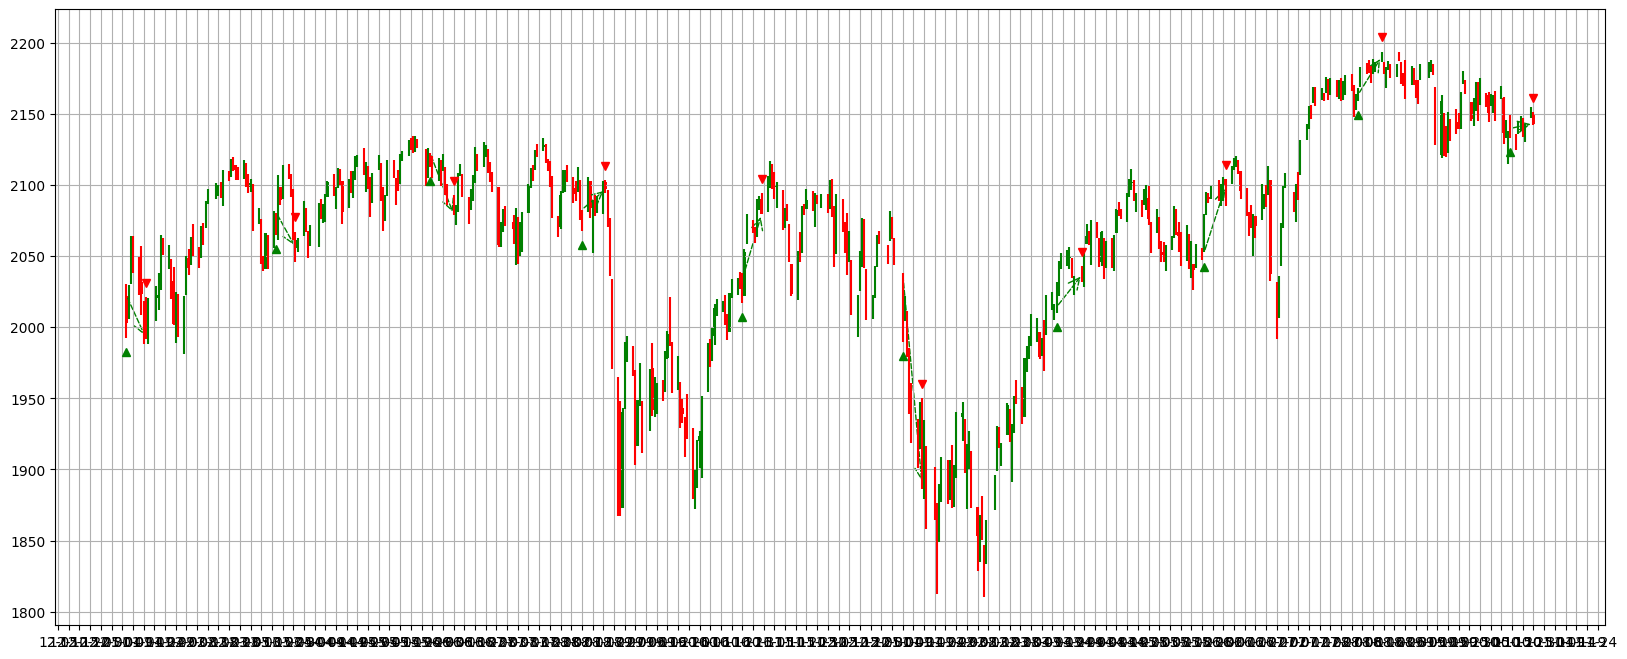

In [49]:
total_profit, profit_table = evaluater.build_profit_table_strategy_1(result_table, all_data, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = -85.22021484375


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-01-06,2022.15,2015-01-15,1992.67,valley,-29.48,NaN,NaN,-0.0146 %
1,2015-03-17,2080.59,2015-03-26,2056.15,valley,-24.44,NaN,NaN,-0.0117 %
2,2015-05-28,2122.27,2015-06-08,2079.28,valley,-42.99,NaN,NaN,-0.0203 %
3,2015-08-07,2082.61,2015-08-18,2096.92,valley,14.31,NaN,NaN,0.0069 %
4,2015-10-21,2033.47,2015-10-30,2079.36,valley,45.89,NaN,NaN,0.0226 %
5,2016-01-04,2038.2,2016-01-13,1890.28,valley,-147.92,NaN,NaN,-0.0726 %
6,2016-03-16,2014.24,2016-03-28,2037.05,valley,22.81,NaN,NaN,0.0113 %
7,2016-05-24,2052.65,2016-06-03,2099.13,valley,46.48,NaN,NaN,0.0226 %
8,2016-08-04,2163.51,2016-08-15,2190.15,valley,26.64,NaN,NaN,0.0123 %
9,2016-10-14,2139.68,2016-10-25,2143.16,valley,3.48,NaN,NaN,0.0016 %


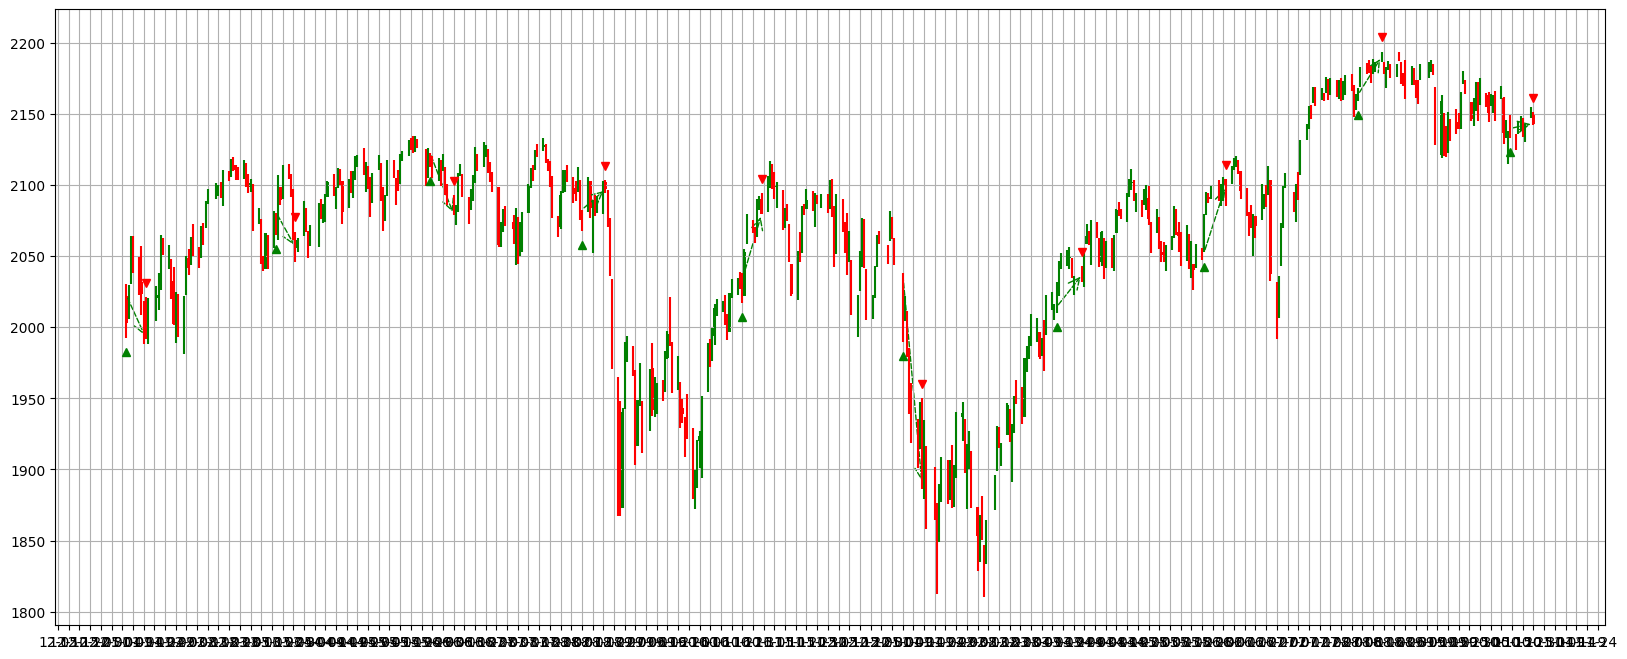

In [50]:
total_profit, profit_table = evaluater.build_profit_table_strategy_2(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

total_profit = -85.22021484375


,in_date,in_price,out_date,out_price,pv,profit,strategy,strategy_price,profitability
0,2015-01-06,2022.15,2015-01-15,1992.67,valley,-29.48,NaN,NaN,-0.0146 %
1,2015-03-17,2080.59,2015-03-26,2056.15,valley,-24.44,NaN,NaN,-0.0117 %
2,2015-05-28,2122.27,2015-06-08,2079.28,valley,-42.99,NaN,NaN,-0.0203 %
3,2015-08-07,2082.61,2015-08-18,2096.92,valley,14.31,NaN,NaN,0.0069 %
4,2015-10-21,2033.47,2015-10-30,2079.36,valley,45.89,NaN,NaN,0.0226 %
5,2016-01-04,2038.2,2016-01-13,1890.28,valley,-147.92,NaN,NaN,-0.0726 %
6,2016-03-16,2014.24,2016-03-28,2037.05,valley,22.81,NaN,NaN,0.0113 %
7,2016-05-24,2052.65,2016-06-03,2099.13,valley,46.48,NaN,NaN,0.0226 %
8,2016-08-04,2163.51,2016-08-15,2190.15,valley,26.64,NaN,NaN,0.0123 %
9,2016-10-14,2139.68,2016-10-25,2143.16,valley,3.48,NaN,NaN,0.0016 %


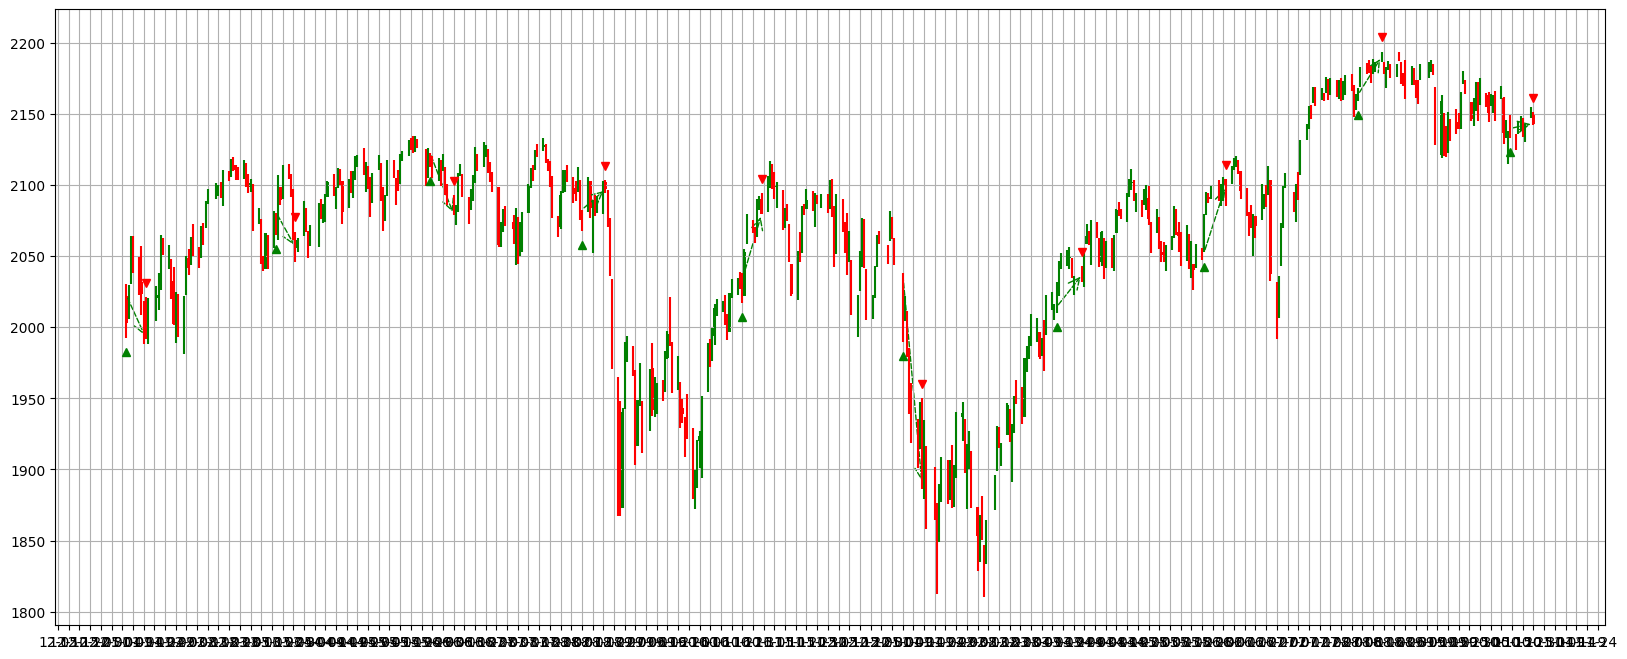

In [51]:
total_profit, profit_table = evaluater.build_profit_table_strategy_3(result_table, all_data, profit_percentage, loss_percentage, pv_range)
print('total_profit =', total_profit)
with pd.option_context('display.max_rows', None,
                    'display.max_columns', None,
                    'display.precision', 3,
                    ):
    display(profit_table)
evaluater.draw_profit_plot(profit_table, all_data)

In [52]:
# fig, ax = plt.subplots(2, 1, figsize=(20, 8), sharex=True)
# ax[0].plot(y_test[0].flatten(), label='y_test')
# ax[1].plot(lstm_processed_signal[0].flatten(), label='signal')
# # for x , pv in enumerate(pv_test_data[0]):
# #     if pv == 1:
# #         ax[0].plot(x, y_test[0].flatten()[x], '^', color='orange')
# #     elif pv == -1:
# #         ax[0].plot(x, y_test[0].flatten()[x], 'v', color='red')
# # for x , pv in enumerate(pv_signal[0]):
# #     if pv == 1:
# #         ax[1].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
# #     elif pv == -1:
# #         ax[1].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
# ax[0].legend()
# ax[1].legend()
# plt.show()

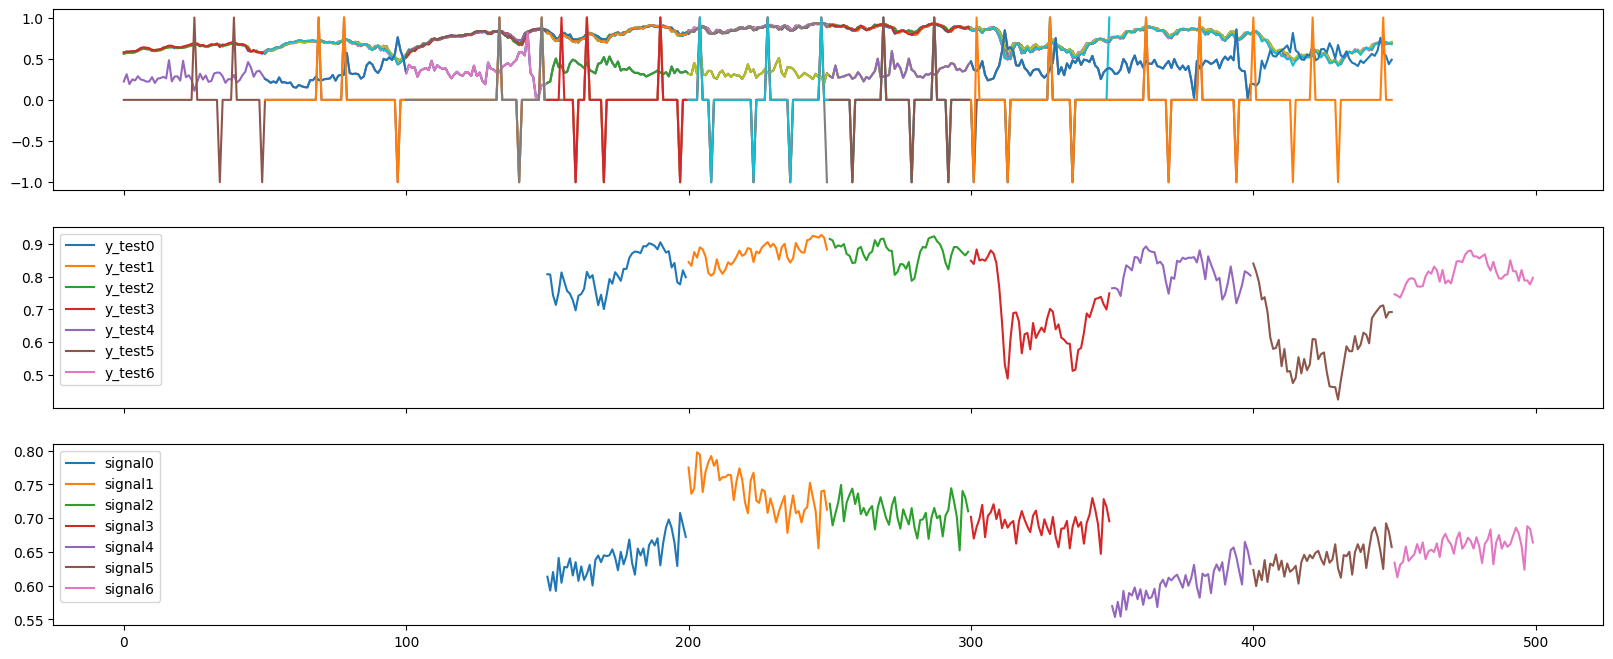

In [58]:
fig, ax = plt.subplots(3, 1, figsize=(20, 8), sharex=True)
count=0
for i in range(0, x_test.shape[1]): 
    # print(i)
    countx=range(count, count+x_length)
    county=range(count+x_length, count+x_length+y_length)
    ax[0].plot(countx, x_test[0, i, :], label=f'x_test{i}')
    ax[1].plot(county, y_test[0, i], label=f'y_test{i}')
    ax[2].plot(county, lstm_processed_signal[0, i], label=f'signal{i}')
    count+=slide
# for x , pv in enumerate(pv_test_data[0]):
#     if pv == 1:
#         ax[1].plot(x, y_test[0].flatten()[x], '^', color='orange')
#     elif pv == -1:
#         ax[1].plot(x, y_test[0].flatten()[x], 'v', color='red')
# for x , pv in enumerate(pv_signal[1]):
#     if pv == 1:
#         ax[2].plot(x, lstm_processed_signal[0].flatten()[x], '^', color='orange')
#     elif pv == -1:
#         ax[2].plot(x, lstm_processed_signal[0].flatten()[x], 'v', color='red')
# ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

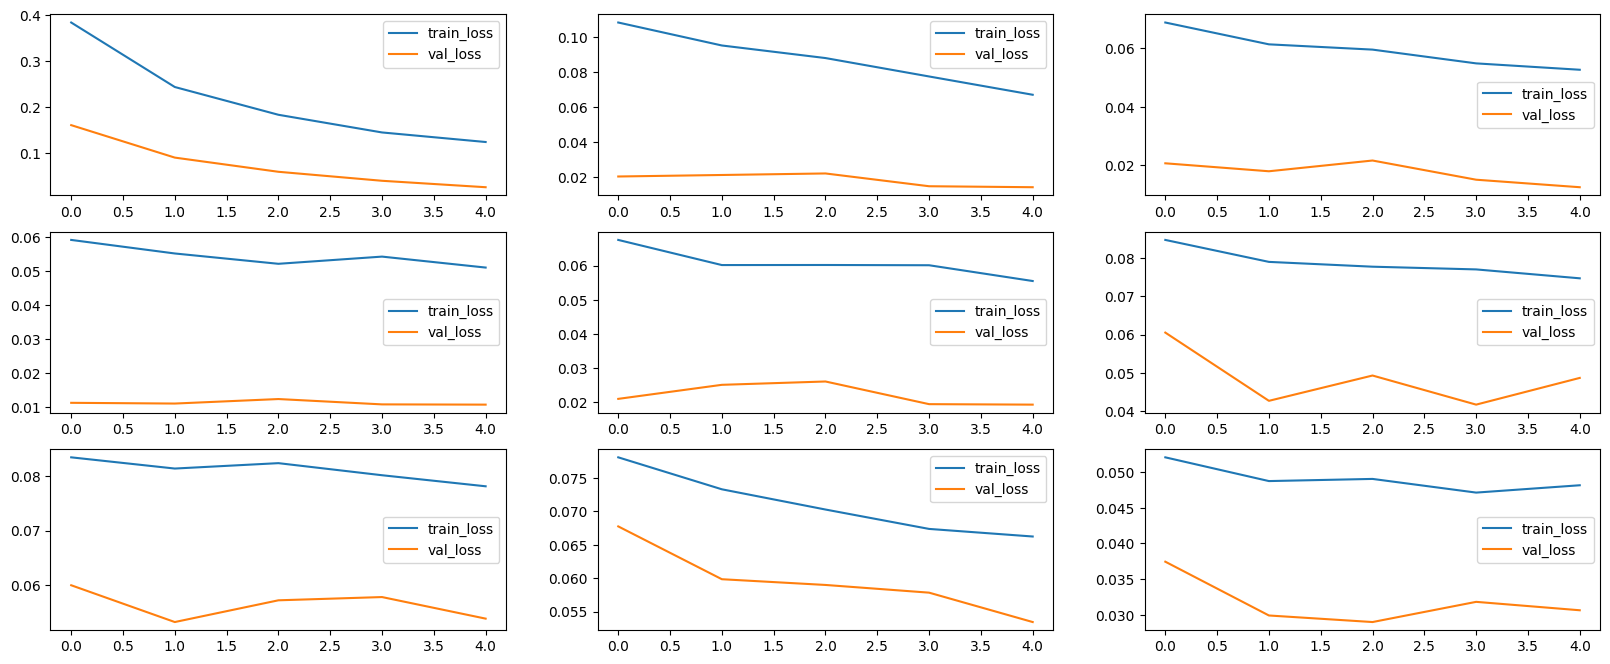

In [54]:
fig, ax = plt.subplots(3, 3, figsize=(20, 8))
i=0
for window in range(9):
    # visualizing losses and accuracy
    train_loss = history[window].history['loss']
    val_loss   = history[window].history['val_loss']
    # plt.title(f'window{window}')
    ax[i//3, i%3].plot(train_loss, label='train_loss')
    ax[i//3, i%3].plot(val_loss, label='val_loss')
    ax[i//3, i%3].legend()
    i+=1
plt.show()


In [55]:
def compute_rmse(predict_value, actual_value):
    absolute_error = np.abs(predict_value - actual_value)
    rmse = np.sqrt(np.mean(absolute_error**2))
    return rmse

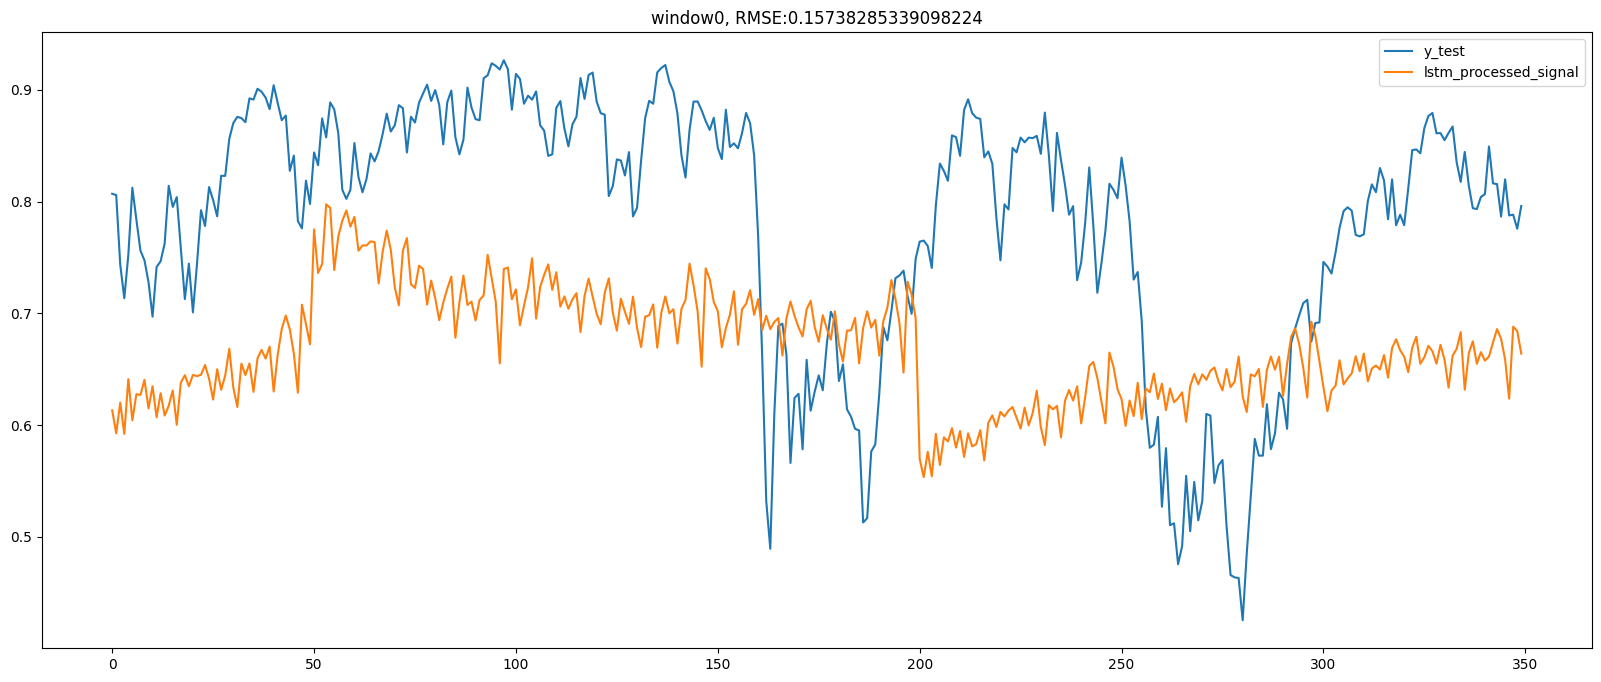

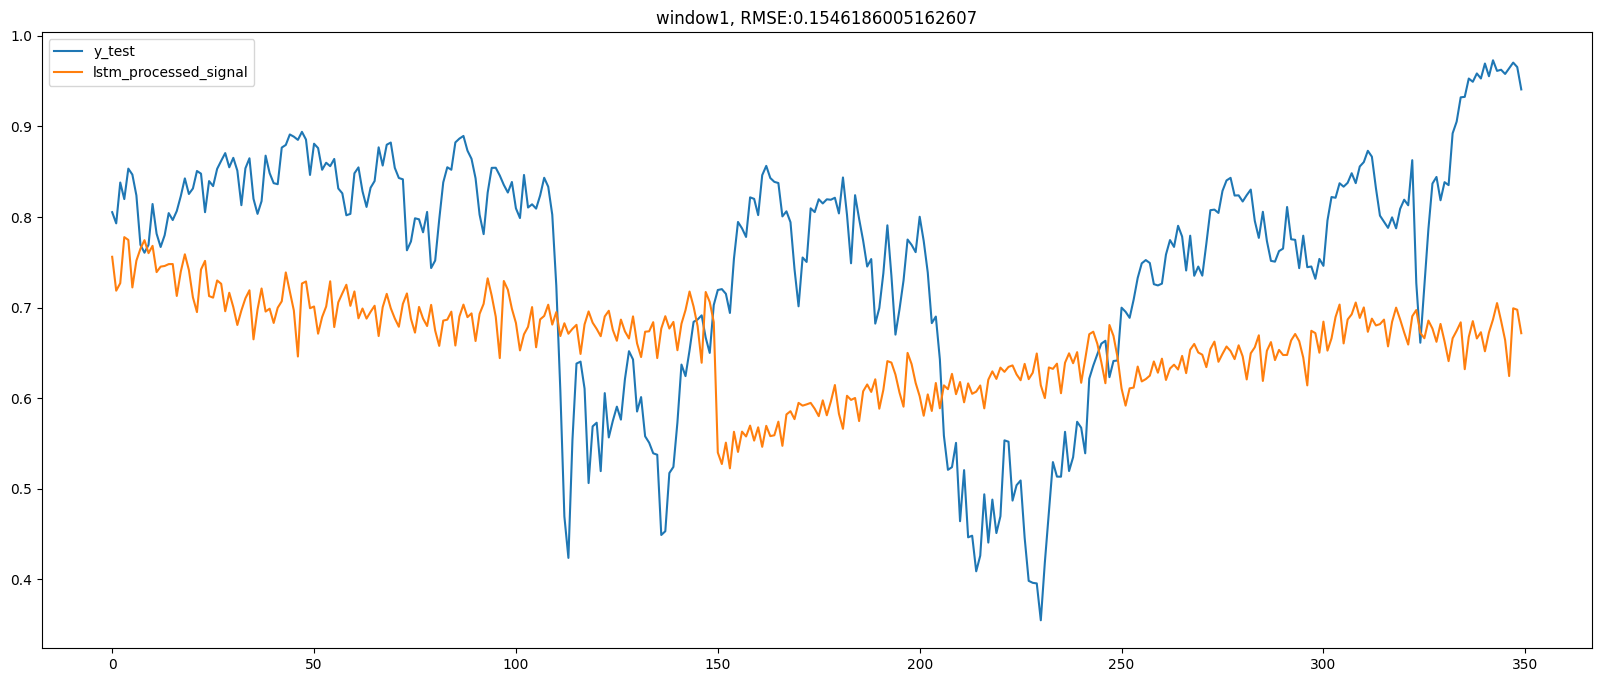

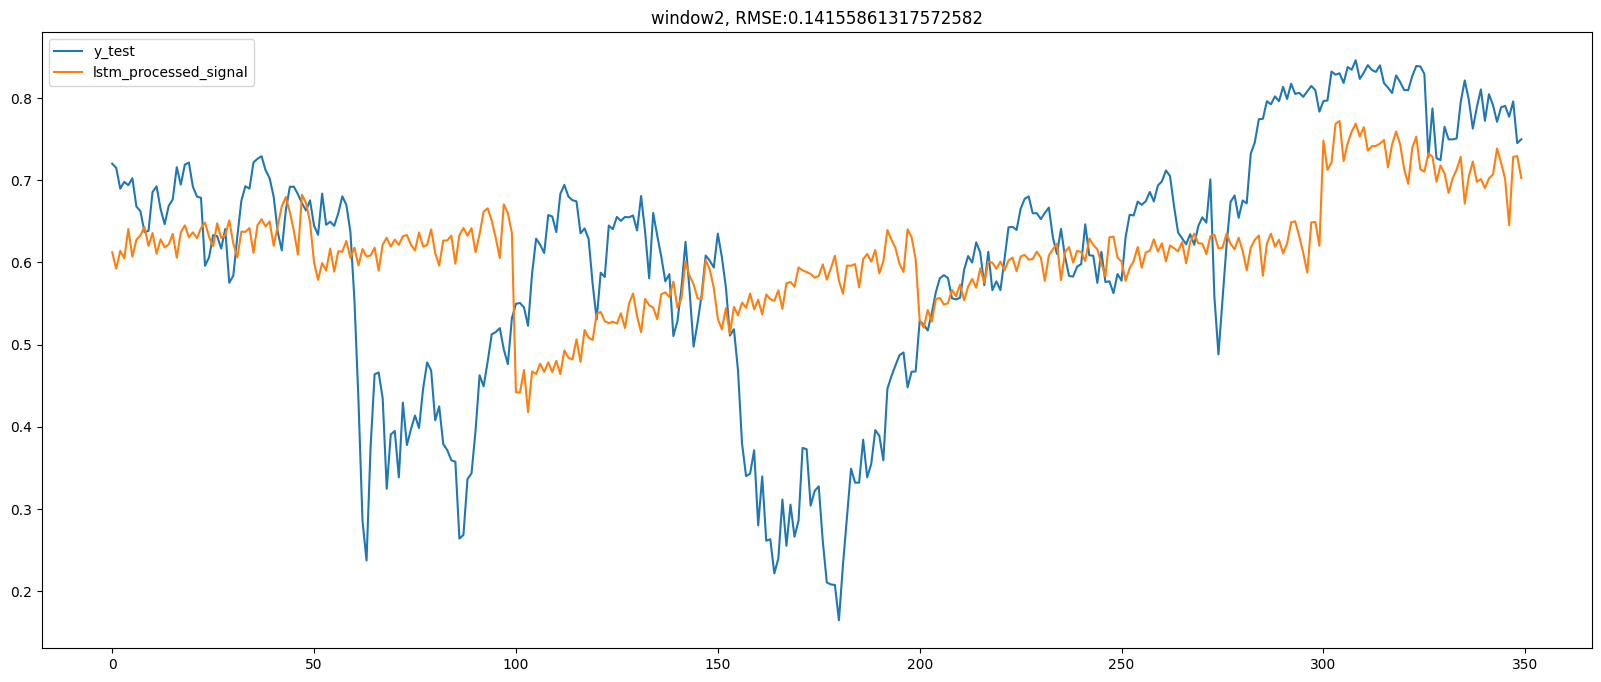

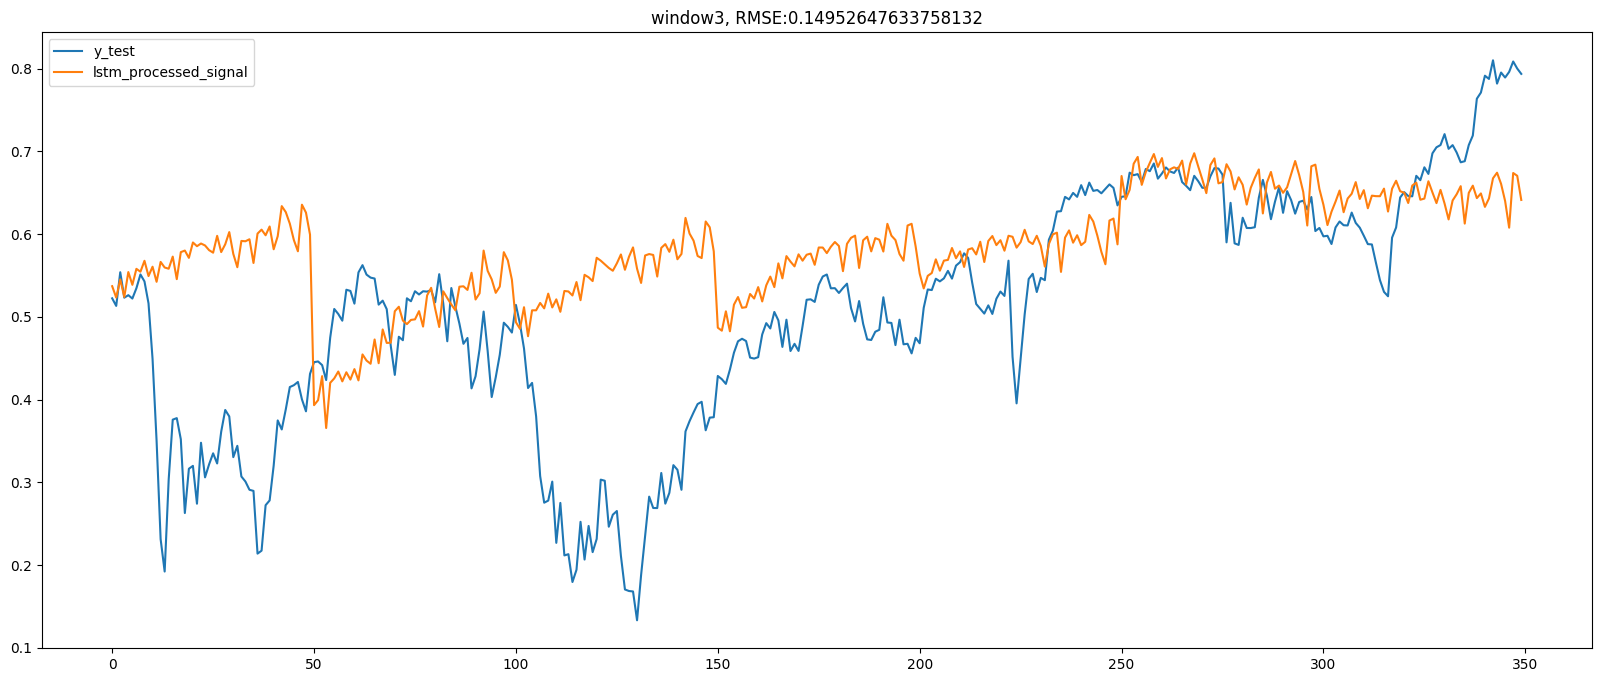

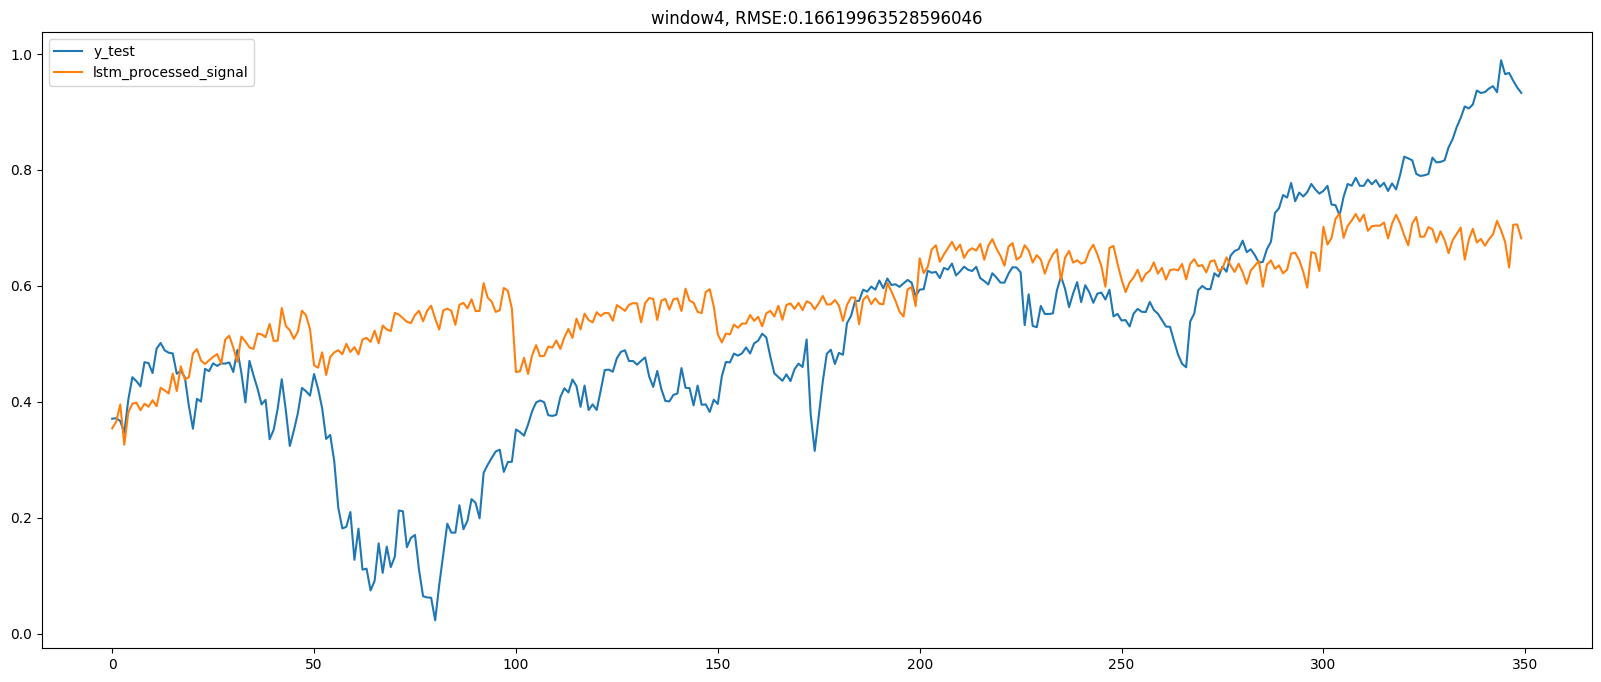

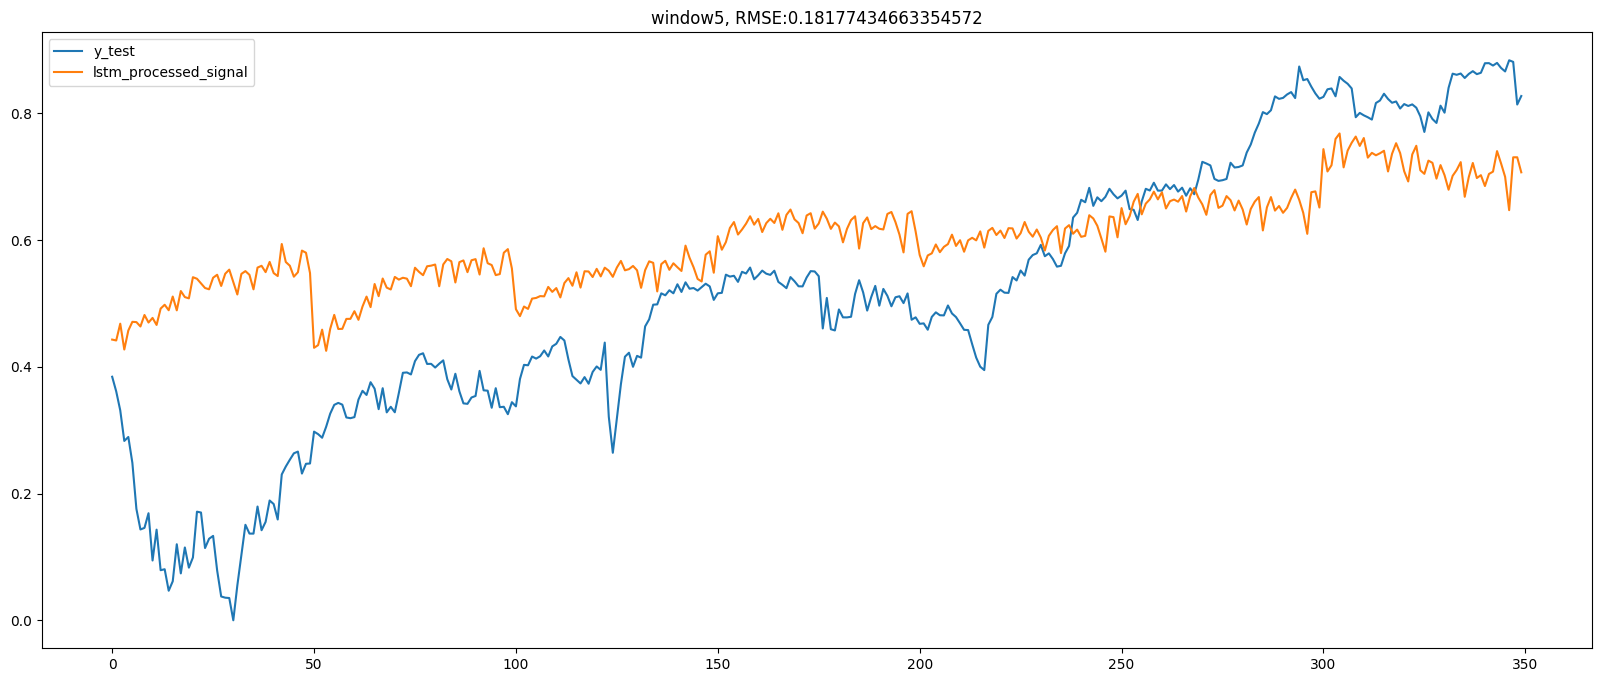

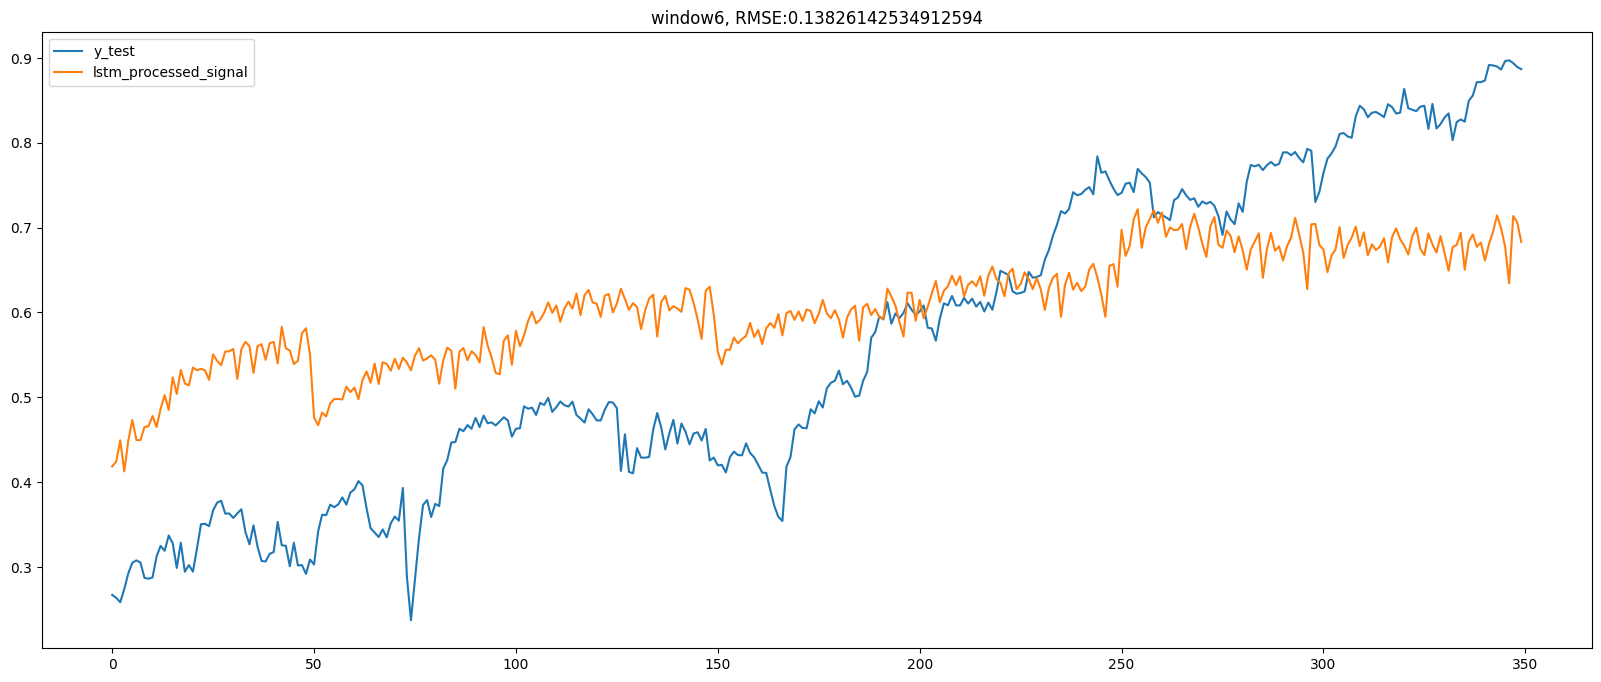

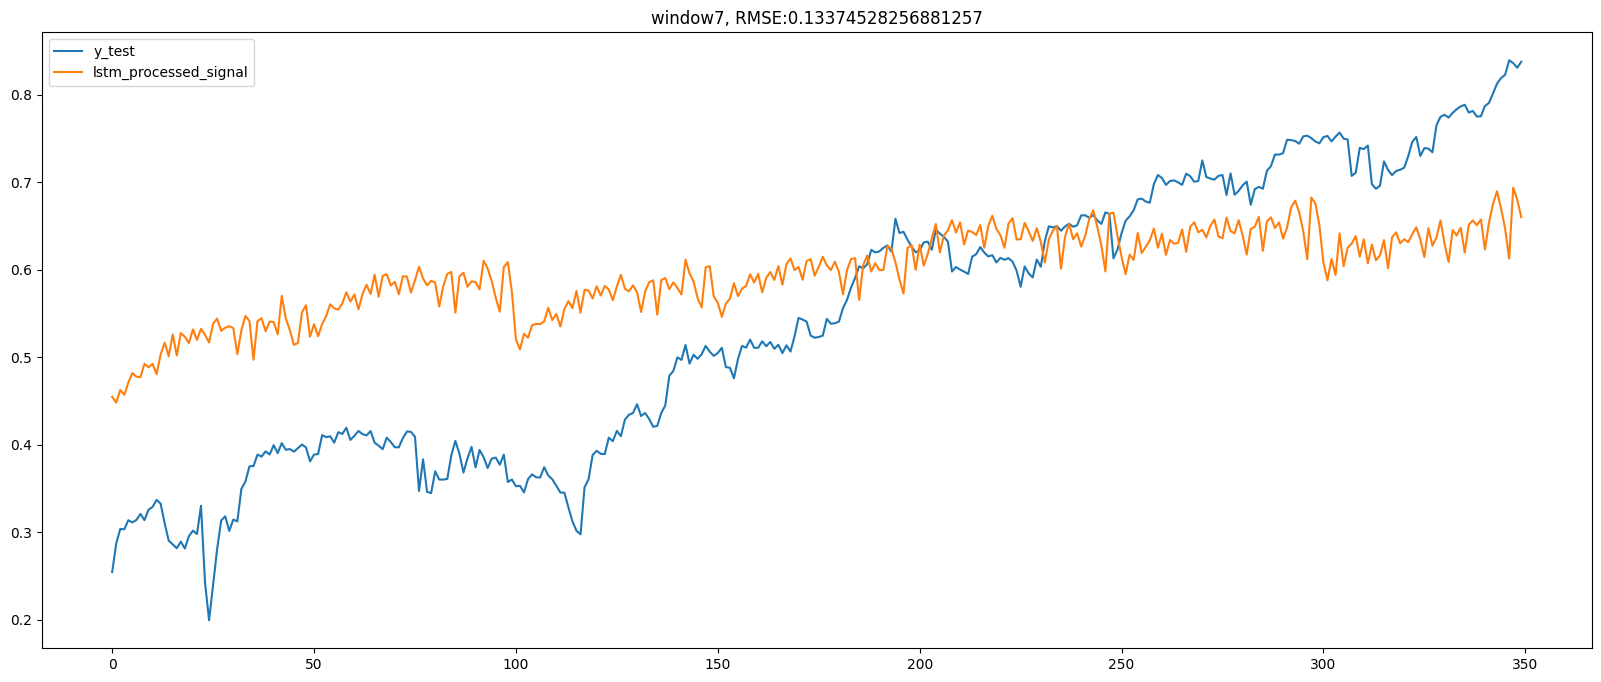

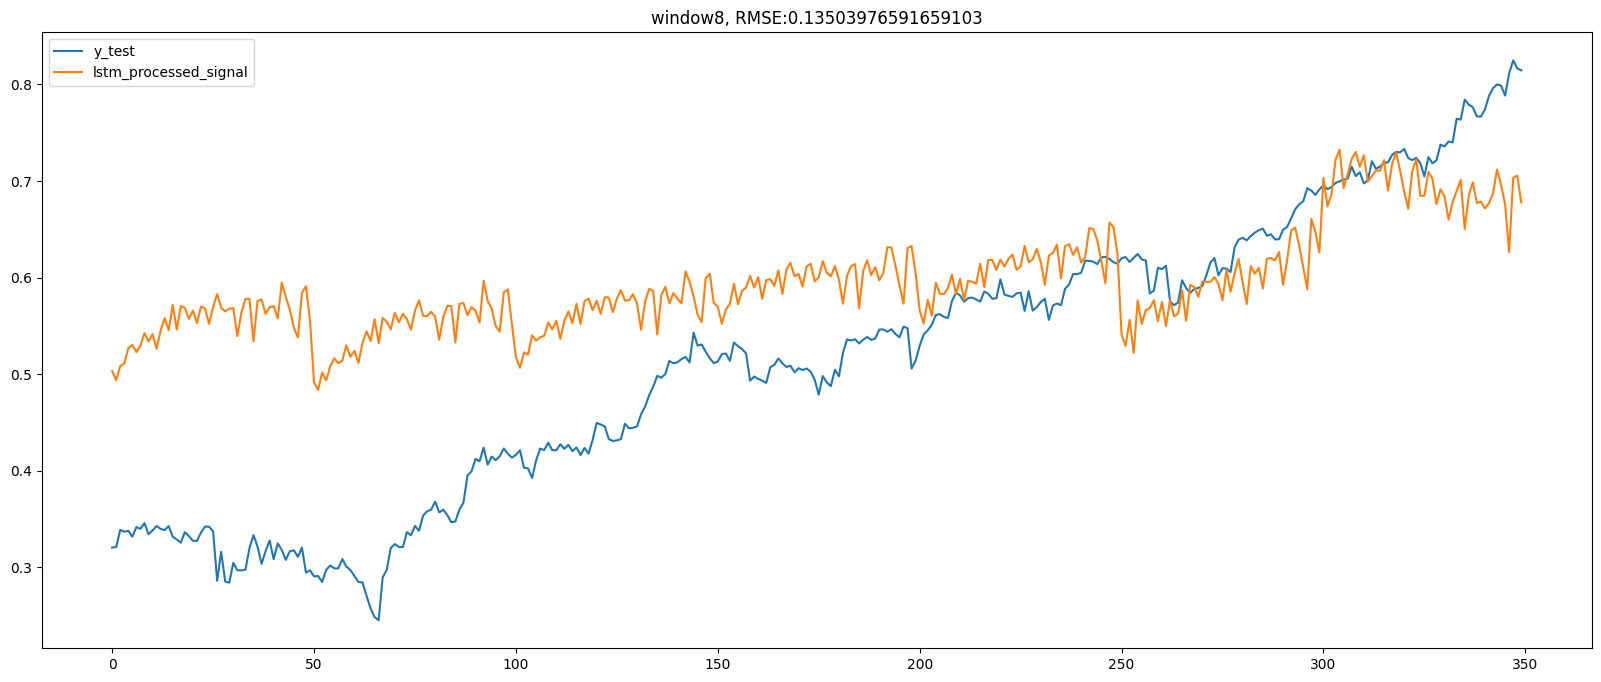

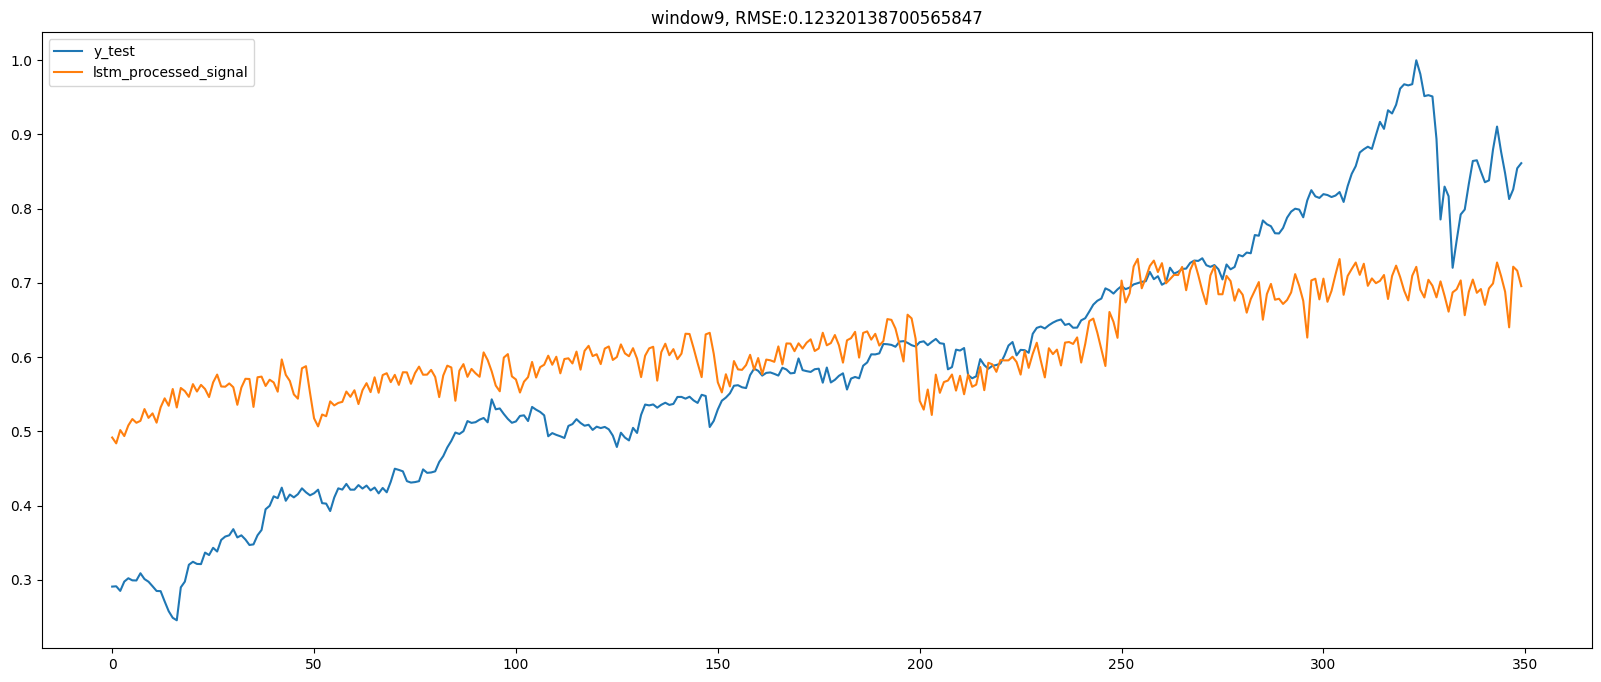

average_rmse=0.14813083861802442


In [56]:
rmse_list = list()
for window in range(test_data.shape[0]):
    RMSE = compute_rmse(lstm_processed_signal[window].flatten(), y_test[window].flatten())
    rmse_list.append(RMSE)
    plt.figure(figsize=(20, 8))
    plt.title(f'window{window}, RMSE:{RMSE}')
    plt.plot(y_test[window].flatten(), label='y_test')
    plt.plot(lstm_processed_signal[window].flatten(), label='lstm_processed_signal')
    plt.legend()
    plt.show()
average_rmse = sum(rmse_list) / len(rmse_list)
print(f'average_rmse={average_rmse}')